In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (6, 6)

import sys
sys.path.insert(0, '..')

Random forests and neural networks are powerful, but hard to explain. Linear models have interpretable coefficients, but they have hard time handling data which is not linearly separable. But near a given example data could be approximated well using a simpler classifier. The idea of LIME algorithm is to sample examples from a small neighborhood of a given example, and use a simpler estimator to approximate predictions of a black-box model.

Let's try it with a synthetic dataset.

In [2]:
import numpy as np
import pandas as pd
from matplotlib import cm
from IPython.display import HTML, display_html, display

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, ElasticNet, Ridge, RidgeCV, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier


from eli5.lime.samplers import UnivariateKernelDensitySampler, MultivariateKernelDensitySampler
from eli5.lime import _train_local_classifier
from eli5 import explain_prediction, explain_weights, format_as_html
from eli5.formatters import fields

cmap = cm.get_cmap('viridis')

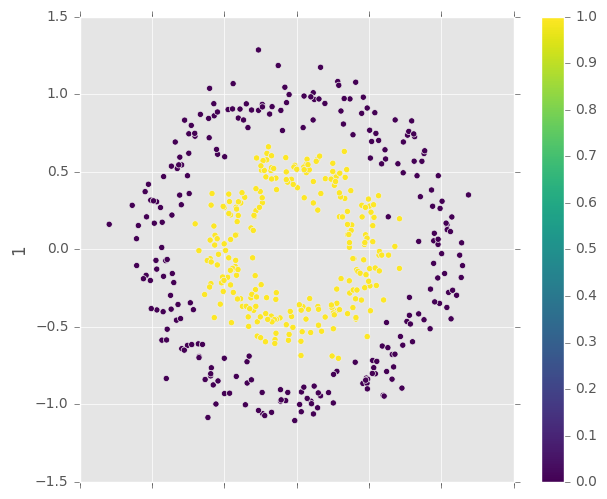

In [3]:
X, y = make_circles(noise=0.10, factor=0.5, n_samples=500)
X_train, X_test, y_train, y_test = train_test_split(X, y)
pd.DataFrame(X).plot.scatter(x=0, y=1, c=y, colormap=cmap, figsize=(7,6))

Random Forest can approximate data well:

In [4]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.93600000000000005

Logistic Regression can't:

In [5]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.35199999999999998

## Generating similar data

Univariate KDE sampler doesn't catch structure of data well, but it still can be used to sample data locally.
Multivariate KDE sampler learned to sample data in a circle.

With small sigma values the neighborhood is too small (almost no examples of different classes).
With large sigma values the neighborhood is too large (data separation is highly non-linear and hard to learn).

In [6]:
doc = np.asarray([-0.3, 0.5])

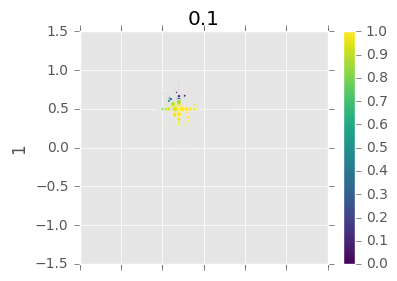

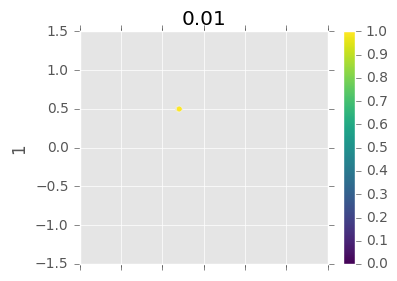

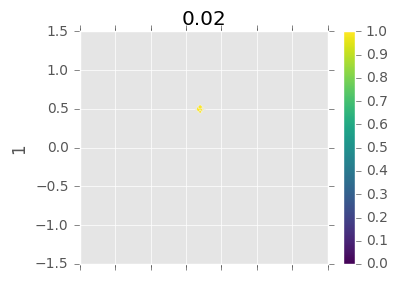

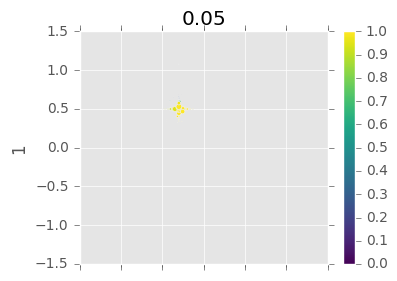

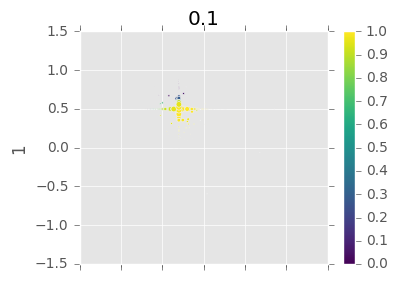

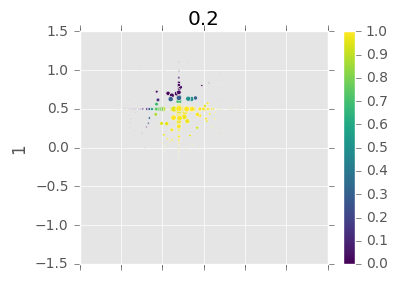

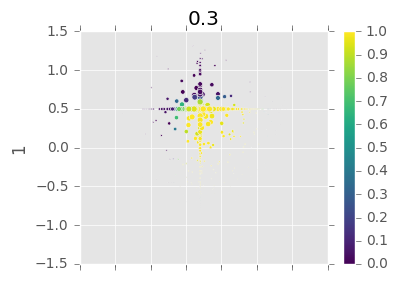

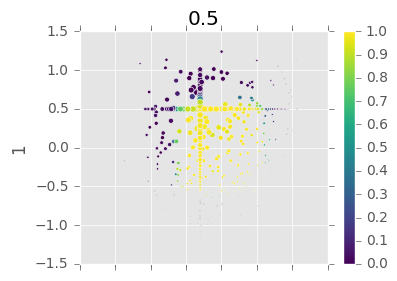

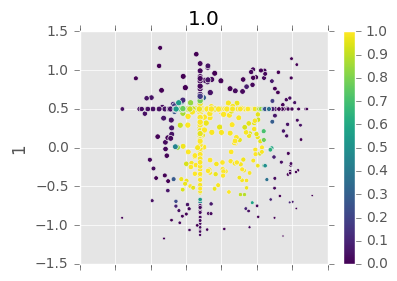

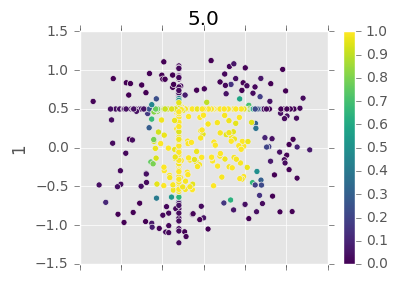

In [7]:
for sigma in ['bandwidth', 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0, 5.0]:
    us = UnivariateKernelDensitySampler(sigma=sigma)
    us.fit(X_train)
    X_sampled_us, similarity = us.sample_near(doc, n_samples=500)
    pd.DataFrame(X_sampled_us).plot.scatter(x=0, y=1, s=similarity*20, figsize=(4,3), 
                                            c=rf.predict_proba(X_sampled_us)[:,1], 
                                            colormap=cmap,
                                            title=str(us.sigma_))

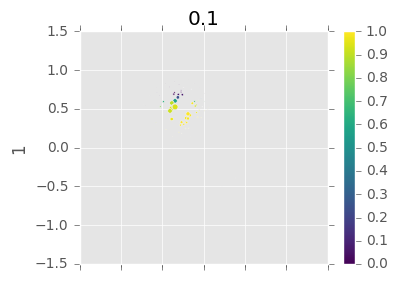

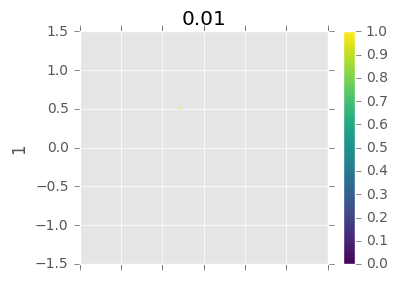

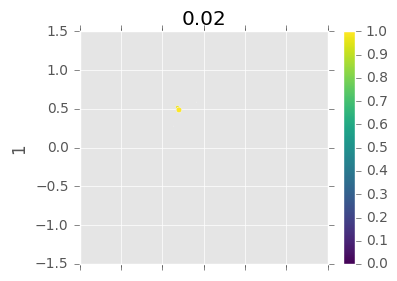

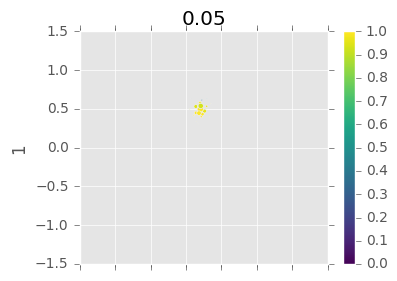

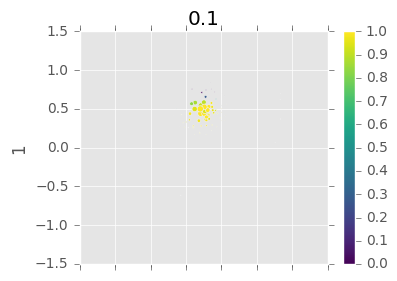

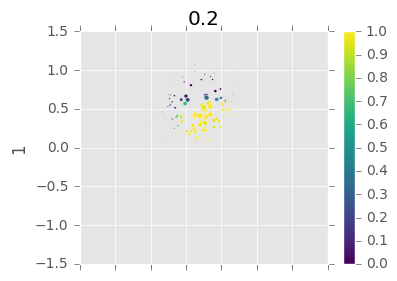

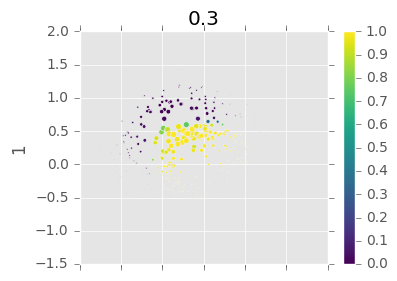

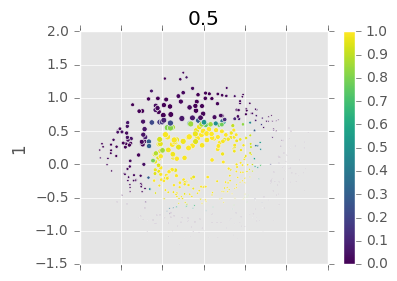

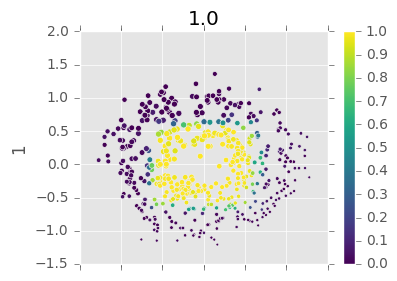

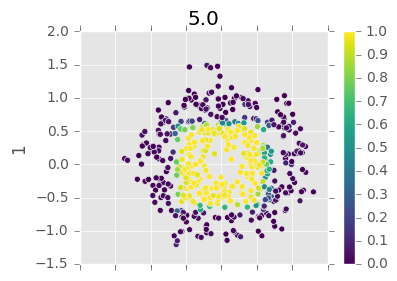

In [8]:
for sigma in ['bandwidth', 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0, 5.0]:
    ms = MultivariateKernelDensitySampler(sigma=sigma)
    ms.fit(X_train)
    X_sampled_ms, similarity = ms.sample_near(doc, n_samples=500)
    pd.DataFrame(X_sampled_ms).plot.scatter(x=0, y=1, s=similarity*20, figsize=(4, 3), 
                                            c=rf.predict_proba(X_sampled_ms)[:,1],
                                            colormap=cmap,
                                            title=str(ms.sigma_))

In [9]:
target_names = np.array(['outer', 'inner'])
feature_names = ['x', 'y']

In [10]:
proba = rf.predict_proba(doc.reshape(1, -1))
proba, target_names[proba.argmax()]

(array([[ 0.,  1.]]), 'inner')

Let's use LogisticRegression to explain prediction of RandomForest at a single data point using LIME algorithm.

To do that, we need to 

1. define neighborhood and generate samples from it;
2. train a local classifier;
3. explain its decisions.

The most tricky part is defining neighborhood and sampling from it. eli5.lime.samplers help, but you still need to choose a good sigma value.

At (-0.3, 0.5) point model should predict "inner" label; to get from outer to inner it is required to either decrease y or increase x, or do both; y is an easier way. It means a linear explanation should have positive feature for x and a larger negative feature for y.

In [11]:
doc

array([-0.3,  0.5])

In [12]:
# doc = np.array([0.0, 1.0])

In [13]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import SGDClassifier

sigma=bandwidth, metrics: (mean_KL_divergence=0.0420; score=0.8397), point *y=inner* probability: LR=0.911, RF=1.000


Weight,Feature
+10.781,<BIAS>
+4.396,x
-14.278,y






sigma=0.01, metrics: (mean_KL_divergence=0.1792; score=1.0000), point *y=inner* probability: LR=0.500, RF=1.000


Weight,Feature
+0.000,<BIAS>
+0.000,y
-0.000,x






sigma=0.02, metrics: (mean_KL_divergence=0.0607; score=0.9999), point *y=inner* probability: LR=0.945, RF=1.000


Weight,Feature
+2.111,<BIAS>
+1.135,y
-0.565,x






sigma=0.05, metrics: (mean_KL_divergence=0.0138; score=0.9984), point *y=inner* probability: LR=0.997, RF=1.000


Weight,Feature
+4.312,<BIAS>
+2.022,y
-1.109,x






sigma=0.1, metrics: (mean_KL_divergence=0.0683; score=0.9971), point *y=inner* probability: LR=0.927, RF=1.000


Weight,Feature
+11.493,<BIAS>
+6.280,x
-14.140,y






sigma=0.2, metrics: (mean_KL_divergence=0.0763; score=0.9349), point *y=inner* probability: LR=0.847, RF=1.000


Weight,Feature
+10.130,<BIAS>
+6.019,x
-13.234,y






sigma=0.3, metrics: (mean_KL_divergence=0.1697; score=0.9356), point *y=inner* probability: LR=0.685, RF=1.000


Weight,Feature
+7.399,<BIAS>
+6.046,x
-9.618,y






sigma=0.5, metrics: (mean_KL_divergence=0.4521; score=0.7880), point *y=inner* probability: LR=0.486, RF=1.000


Weight,Feature
+2.748,<BIAS>
+2.481,x
-4.117,y






sigma=1.0, metrics: (mean_KL_divergence=0.5488; score=0.6299), point *y=inner* probability: LR=0.412, RF=1.000


Weight,Feature
+0.596,x
+0.281,<BIAS>
-0.911,y






sigma=5.0, metrics: (mean_KL_divergence=0.5317; score=0.4476), point *y=inner* probability: LR=0.448, RF=1.000


Weight,Feature
+0.010,x
-0.083,<BIAS>
-0.249,y


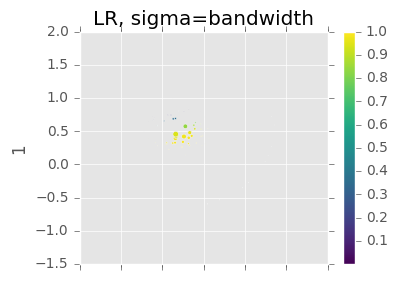

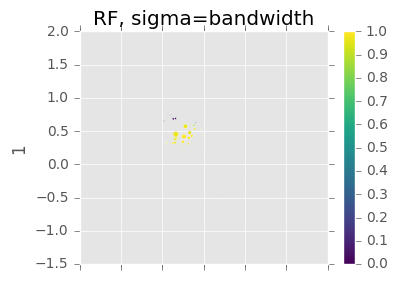

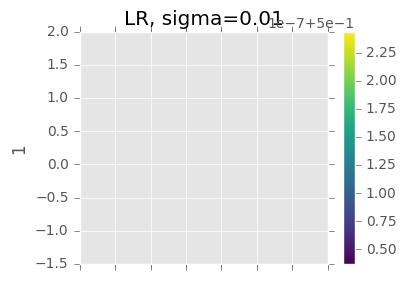

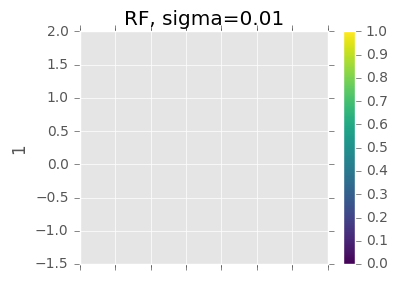

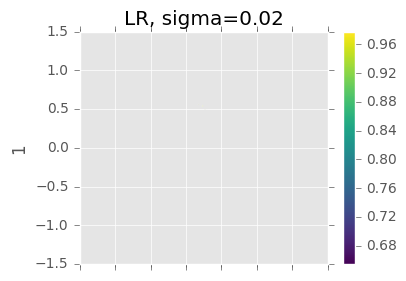

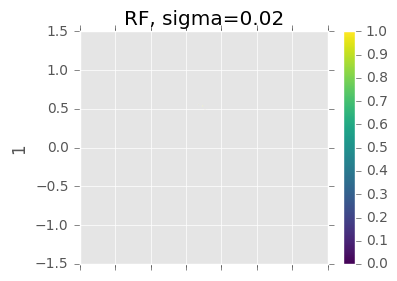

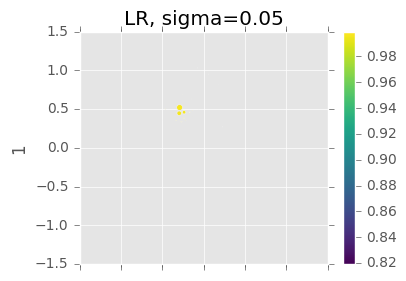

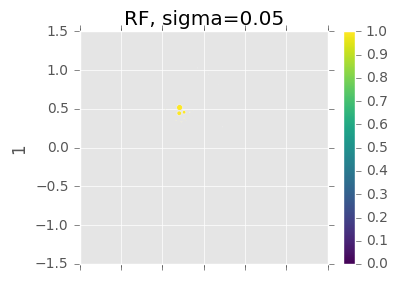

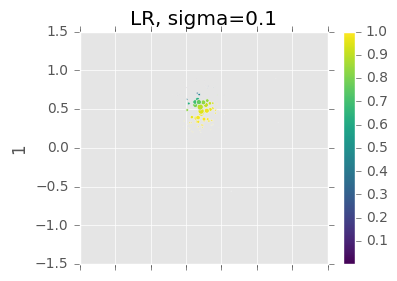

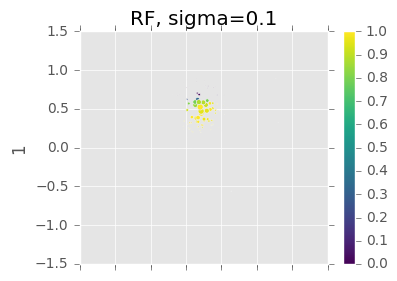

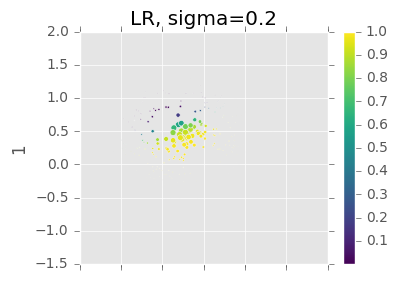

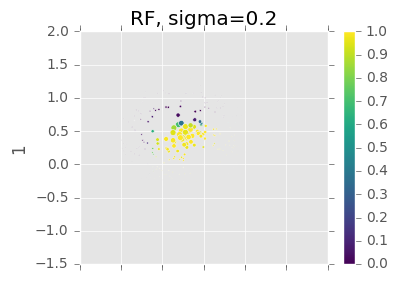

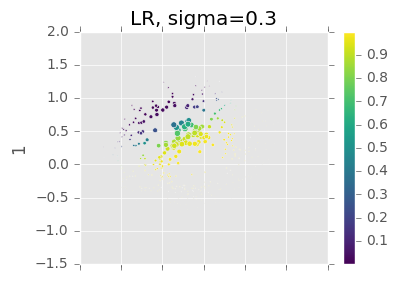

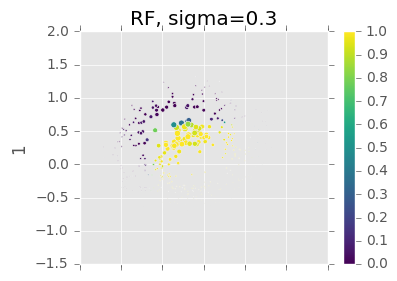

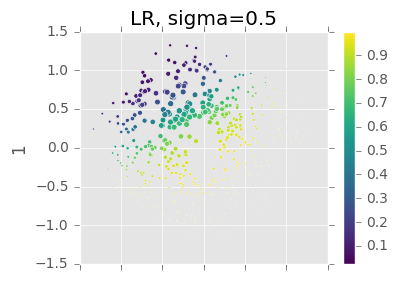

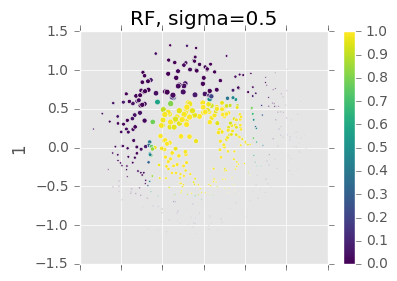

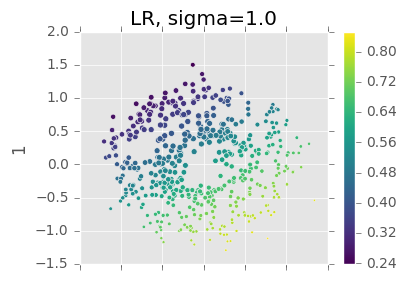

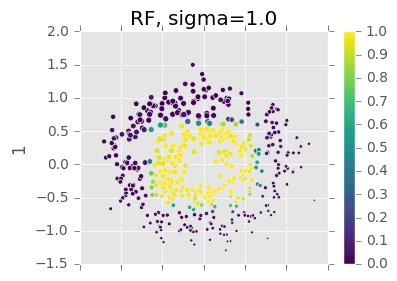

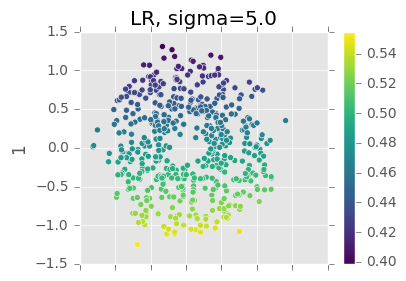

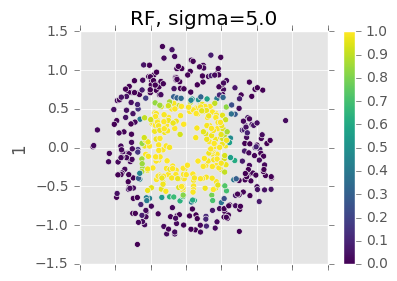

In [14]:
for sigma in ['bandwidth', 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0, 5.0]:
#     s = UnivariateKernelDensitySampler(sigma=sigma)
    s = MultivariateKernelDensitySampler(sigma=sigma)
    s.fit(X_train)
    samples, similarity = s.sample_near(doc, n_samples=500)

    est = LogisticRegression(fit_intercept=True, C=100)
#     est = DecisionTreeClassifier(max_depth=2)
#     est = SGDClassifier(loss='log')
    scores = _train_local_classifier(est, samples, similarity, rf.predict_proba)    

#     est = Ridge(fit_intercept=False, alpha=1e-2)
#     y_proba = rf.predict_proba(samples)[:, 1]
#     est.fit(samples, y_proba, sample_weight=similarity)    
#     score = 0

    def _predict(X):
#         return est.predict(X)
        return est.predict_proba(X)[:,1]

    def format_metrics(dct):
        return "; ".join("{}={:.4f}".format(k, v) for k, v in sorted(dct.items()))

    print("sigma={}, metrics: ({}), point *y={}* probability: LR={:.3f}, RF={:.3f}".format(
        sigma, format_metrics(scores), target_names[1],
        _predict([doc])[0],
        rf.predict_proba([doc])[0, 1],    
    ))
    
#     expl = explain_prediction(est, doc, target_names=target_names, feature_names=feature_names)
    expl = explain_weights(est, target_names=target_names, feature_names=feature_names)
    display(HTML(format_as_html(expl, show=fields.WEIGHTS)))

    pd.DataFrame(samples).plot.scatter(x=0, y=1, s=similarity*20, figsize=(4,3), 
                                       c=_predict(samples), colormap=cmap, 
                                       title='LR, sigma=%s' % sigma)    
    pd.DataFrame(samples).plot.scatter(x=0, y=1, s=similarity*20, figsize=(4,3), 
                                       c=rf.predict_proba(samples)[:,1], colormap=cmap,
                                       title='RF, sigma=%s' % sigma)

    print("\n"*3)

For small, but not tiny sigma values (== small, but not tiny neighborhoods) LogisticRegression is able to approximate RandomForest well (score is close to 1.0, predicted probability is close to RandomForest).

When sigma is too small there is not enough data for training: all points look almost the same, and the prediction is explained mostly by `<BIAS>` feature; when sigma is large there is too much data and it is no longer local. In this example 0.2 and 0.3 sigma values look reasonable, 0.1 and 0.5 are worse, but also ok. When sigma < 0.1 the data is too 'flat' and classifier explains it by bias; when sigma > 0.3 the data becomes too complex for a linear classifier.

In "good" sigma range coefficients make sense: y is negative, meaning we should go up to get from the inner circle; x is positive, meaning we should go left to get from inner to outer; bias is positive, meaning that we're in inner circle.

TODO: how to choose sigma? Incorrect sigma value => explanation which doesn't make sense.

In a small neighborhood most examples can be from the same class, so it is easy to get good accuracy. KL divergence is a measure of how well probabilities are approximated..